<a href="https://colab.research.google.com/github/Droid008/Introduction-to-the-processing-of-a-natural-language/blob/Lesson-%234/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

In [7]:
import pandas as pd
import numpy as np

import re
import nltk

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from gensim.models import *
from gensim import corpora

from tqdm.notebook import tqdm

In [8]:
col_names = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 'tfoll', 'tfrien', 'listcount']

In [9]:
positive_df = pd.read_csv('positive.csv', sep=';', header=None, index_col=0, names=col_names, encoding='utf-8')
positive_df.head()

,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
id,,,,,,,,,,,
408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [10]:
negative_df = pd.read_csv('negative.csv', sep=';', header=None, index_col=0, names=col_names, encoding='utf-8')
negative_df.head()

,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
id,,,,,,,,,,,
408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [11]:
combine_df = positive_df.iloc[:, 2].append(negative_df.iloc[:, 2], ignore_index=True)
combine_df = combine_df.dropna().drop_duplicates()
combine_df.head()

0    @first_timee хоть я и школота, но поверь, у на...
1    Да, все-таки он немного похож на него. Но мой ...
2    RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3    RT @digger2912: "Кто то в углу сидит и погибае...
4    @irina_dyshkant Вот что значит страшилка :D\nН...
Name: ttext, dtype: object

In [12]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
morpher = MorphAnalyzer()
sw_ru = set(get_stop_words("ru"))

In [13]:
#1. избавимся от букв латинского алфавита, чисел, знаков препинания и всех символов, например, символ @ встречается почти везде;
#2. разобьем пост на токены;
#3. проведем лемматизацияю, получив нормальную (начальную) форму слова;
#4. удалим стоп-слова и слова с длиной менее 3х символов.
def preprocess_txt(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in sw_ru:
            token = token.strip()
            token = morpher.normal_forms(token)[0]
            if len(token) > 2:
                tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [14]:
%%time
data = combine_df.apply(preprocess_txt)
data = data.dropna()

CPU times: user 4min 35s, sys: 1.18 s, total: 4min 36s
Wall time: 4min 50s


In [15]:
data[:5]

0    [школотый, поверь, самый, общество, профилиров...
1                      [таки, похожий, мальчик, равно]
3    [кто, угол, сидеть, погибать, голод, порция, в...
4    [вот, страшилка, блин, посмотреть, часть, созд...
5                                 [любить, знать, бля]
Name: ttext, dtype: object

In [16]:
dictionary = corpora.Dictionary(data)

dictionary.filter_extremes(no_below=10,
                           no_above=0.9,
                           keep_n=None) #игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweets.dict')

In [17]:
corpus = [dictionary.doc2bow(text) for text in data]
corpora.MmCorpus.serialize('tweets.model', corpus)

In [18]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 4min 51s, sys: 1.77 s, total: 4min 53s
Wall time: 4min 52s


In [23]:
lda.show_topics(num_topics=3, num_words=20, formatted=True)

[(3,
  '0.155*"мочь" + 0.035*"прийтись" + 0.029*"дать" + 0.026*"столько" + 0.025*"получиться" + 0.024*"чувствовать" + 0.024*"ужас" + 0.023*"нормально" + 0.023*"боль" + 0.022*"нету" + 0.021*"место" + 0.015*"ночью" + 0.012*"алгебра" + 0.010*"английский" + 0.010*"лох" + 0.009*"грустный" + 0.009*"дождь" + 0.008*"сложно" + 0.008*"бред" + 0.007*"приходиться"'),
 (11,
  '0.055*"плохо" + 0.055*"утро" + 0.042*"вчера" + 0.041*"прийти" + 0.041*"сказать" + 0.040*"забыть" + 0.036*"ужасно" + 0.023*"уехать" + 0.021*"начинать" + 0.019*"душа" + 0.018*"выспаться" + 0.016*"добрый" + 0.014*"утром" + 0.013*"собака" + 0.012*"заснуть" + 0.011*"этот" + 0.011*"общаться" + 0.011*"поздно" + 0.010*"сломать" + 0.009*"просыпаться"'),
 (8,
  '0.076*"самый" + 0.045*"работа" + 0.043*"холодно" + 0.042*"свой" + 0.029*"чувство" + 0.024*"каждый" + 0.023*"еда" + 0.022*"вопрос" + 0.020*"мысль" + 0.018*"начаться" + 0.018*"россия" + 0.015*"искать" + 0.014*"русский" + 0.014*"мир" + 0.010*"неужели" + 0.010*"концерт" + 0.010*"сд

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 16.5 s, sys: 108 ms, total: 16.6 s
Wall time: 23.3 s


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

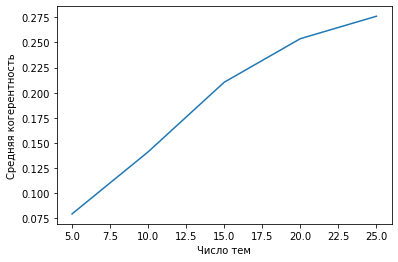

In [26]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [27]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 12.7 s, sys: 162 ms, total: 12.8 s
Wall time: 15.7 s


В целом можно сделать выводы о близких тематиках всех текстов. Это темы связанные с бытовыми аспектами жизни авторов.\
Основное: - Учеба и впечатления школьника.